# Ensemble Models

Contents:
1. [Introduction](#1)
    1. [Ensemble Benefits](#1.1)
2. [Bagging](#2)
    1. [Bootstrap Resampling](#2.1)
    2. [Aggregating](#2.2)
    3. [Bagging](#2.3)
    4. [Bagging Complex Pipelines](#2.4)
3. [Random Forests](#3)
4. [Boosting](#4)
    1. [Adaptive Boosting](4.1)
        1. [Underlying Methodology](#4.1.1)
        2. [In Practice](#4.1.2)
        3. [Overfitting](#4.1.3)
    2. [Gradient Boosting](#4.2)
        1. [Underlying Methodology](#4.2.1)
        2. [Random Forest Comparison](#4.2.2)
        3. [Overfitting & Early-Stopping](#4.2.3)
        4. [Histogram Boosting](#4.2.4)
    
5. [Hyperparameters](#5)

<a id="1" ></a>
## Introduction

Here we will quickly run through the main areas.

### i) <ins>Bagging</ins>

In bagging, we will construct __deep trees independently of one another__.

Each tree will be fitted on a __sub-sampling from the initial data__. i.e. we will only consider a random part of the data to build each model.

When we have to classify a new point, we will __aggregate the predictions of all models in the ensemble with a voting scheme__.

__Each deep tree overfits, but voting makes it possible to cancel out some of the training set noise. The ensemble overfits less than the individual models__.

<table>
    <tr>
        <td> <img src="diagrams/Bagging%20Classification.jpg" width=700/></td> 
        <td> <img src="diagrams/Bagging%20Regression.jpg" width=600/></td>
    </tr>
</table>

### ii) <ins>Bagging versus Random Forests</ins>

__Bagging__ is a general strategy
- Can work with any base model (linear, trees...)

__Random Forests__ are bagged _randomized_ decision trees

- At each split: a random subset of features are selected
- The best split is taken among the restricted subset
- Extra randomization decorrelates the prediction errors
- __Uncorrelated errors make bagging work better__

iii) <ins>Boosting for Classification and Regression</ins>

Ensembling via boosting makes it possible to __progressively refine the predictions__ of the previous model.

At each step we focus on __mistakes of the previous model to correct them__.

Even if the first models are underfitting (shallow trees), adding more trees makes it possible to perfectly classify all the training set data points.

### iv) <ins>Boosting vs Gradient Boosting</ins>

__Traditional Boosting__ `sklearn.ensemble.AdaBoostClassifier`

- Mispredicted samples are re-weighted at each step
- Can use any base model that accepts sample_weight

__Gradient Boosting__ `sklearn.ensemble.HistGradientBoostingClassifier`

- Each base model predicts the negative error of previous models
- sklearn use decision trees as the base model

In practice, gradient boosting is __more flexible__ thanks to the use of __cost functions__ and tend to exhibits __better predictive performance__ than traditional boosting.

### v) <ins>Gradient Boosting and Binned Features (Histogram Boosting)</ins>

- `sklearn.ensemble.GradientBoostingClassifier`

    - Implementation of the traditional (exact) method
    - Fine for small data sets
    - Too slow for n_samples > 10,000
    
- `sklearn.ensemble.HistGradientBoostingClassifier`

    - Discretize numerical features (256 levels)
    - Efficient multi core implementation
    - Much, much faster when n_samples is large
   
Like traditional decision trees __GradientBoostingClassifier and GradientBoostingRegressor__ internally rely on sorting the features values which as an `n * log(n)` time complexity and is therefore __not suitable for large training set__.

__HistGradientBoostingClassifier__ and __HistGradientBoostingRegressor__ use __histograms to approximate feature sorting__ to find the best feature split thresholds and can therefore be trained efficiently on datasets with hundreds of features and tens of millions of data points.

Furthermore they can benefit from running on machines with many CPU cores very efficiently.

### <ins>Key Points:</ins>

- __Bagging__ and __random forests__ fit trees __independently__
    - each deep tree overfits individually
    - averaging the tree predictions reduces overfitting
- (Gradient) __boosting__ fits trees __sequentially__
    - each __shallow tree underfits individually__
    - sequentially adding trees __reduces underfitting__
- __Gradient boosting__ tends to perform slightly better than __bagging__ and __random forest__ and furthermore shallow trees predict faster.

<a id="1.1" ></a>
### Ensemble Benefits

The benefit of ensemble methods over simple models (e.g. decision tree, linear model, etc.) is that combining simple models result in more powerful and robust models with less hassle.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
sklearn.set_config(display="diagram")

In [2]:
# load dataset
from sklearn.datasets import fetch_california_housing
# set target and features
data, target = fetch_california_housing(as_frame=True, return_X_y=True)
target *= 100  # rescale the target in k$

#### i) Basic Tree

In [3]:
%%time
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=0)
# evaluate tree
cv_results = cross_validate(tree, data, target, n_jobs=2)
scores = cv_results["test_score"]

print(f"R2 score obtained by cross-validation: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

R2 score obtained by cross-validation: 0.354 +/- 0.087
Wall time: 4.95 s


#### ii) Tuned Tree

In [4]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# provide parameter values to search from
param_grid = {
    "max_depth": [5, 8, None],
    "min_samples_split": [2, 10, 30, 50],
    "min_samples_leaf": [0.01, 0.05, 0.1, 1]}
cv = 3

# create model that will search for best parameters
tree = GridSearchCV(DecisionTreeRegressor(random_state=0),
                    param_grid=param_grid, cv=cv, n_jobs=2)
# evaulate model
cv_results = cross_validate(tree, data, target, n_jobs=2,
                            return_estimator=True)
scores = cv_results["test_score"]

print(f"R2 score obtained by cross-validation: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

R2 score obtained by cross-validation: 0.523 +/- 0.107
Wall time: 14 s


#### iii) Bagging (Ensemble of basic trees)

In [5]:
%%time
from sklearn.ensemble import BaggingRegressor

# use basic tree as base_estimator
base_estimator = DecisionTreeRegressor(random_state=0)
# create bagging model using 20 trees
bagging_regressor = BaggingRegressor(
    base_estimator=base_estimator, n_estimators=20, random_state=0)
# evaluate model
cv_results = cross_validate(bagging_regressor, data, target, n_jobs=2)
scores = cv_results["test_score"]

print(f"R2 score obtained by cross-validation: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

R2 score obtained by cross-validation: 0.642 +/- 0.083
Wall time: 8.75 s


__Without searching for optimal hyperparameters__, the overall generalization performance of the bagging regressor is __better__ than a single decision tree. In addition, the __computational cost is reduced__ in comparison of seeking for the optimal hyperparameters.

This shows the motivation behind the use of an ensemble learner: it gives a relatively good baseline with decent generalization performance without any parameter tuning.

<a id="2" ></a>
## Bagging

“Bagging” stands for <ins><b>B</b>ootstrap <b>AGG</b>regat<b>ING</b></ins>. It uses __bootstrap resampling__ (random sampling with replacement) to learn several models on random variations of the training set. At predict time, the predictions of each learner are __aggregated__ to give the final predictions.

<a id="2.1" ></a>
### (i) Bootstrap Resampling

A bootstrap sample corresponds to a __resampling with replacement__, of the original dataset, a sample that is the __same size__ as the original dataset. Thus, the bootstrap sample will contain __some data points several times__ while some of the original data points will not be present.

We will create a function that given data and target will return a resampled variation `data_bootstrap` and `target_bootstrap`.

In [6]:
# create a random number generator that will be used to set the randomness
rng = np.random.RandomState(1)


def generate_data(n_samples=30):
    """Generate synthetic dataset. Returns `data_train`, `data_test`,
    `target_train`."""
    x_min, x_max = -3, 3
    x = rng.uniform(x_min, x_max, size=n_samples)
    noise = 4.0 * rng.randn(n_samples)
    y = x ** 3 - 0.5 * (x + 1) ** 2 + noise
    y /= y.std()

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(
        np.linspace(x_max, x_min, num=300), columns=["Feature"])
    target_train = pd.Series(y, name="Target")

    return data_train, data_test, target_train

In [7]:
def bootstrap_sample(data, target):
    # Indices corresponding to a sampling with replacement of the same sample
    # size than the original data
    bootstrap_indices = rng.choice(
        np.arange(target.shape[0]), size=target.shape[0], replace=True,
    )
    # In pandas, we need to use `.iloc` to extract rows using an integer
    # position index:
    data_bootstrap = data.iloc[bootstrap_indices]
    target_bootstrap = target.iloc[bootstrap_indices]
    return data_bootstrap, target_bootstrap

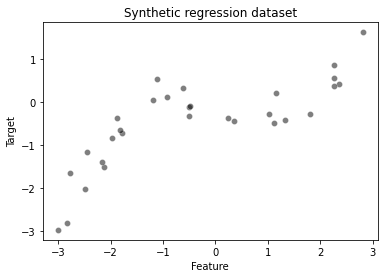

In [8]:
data_train, data_test, target_train = generate_data(n_samples=30)
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
_ = plt.title("Synthetic regression dataset")

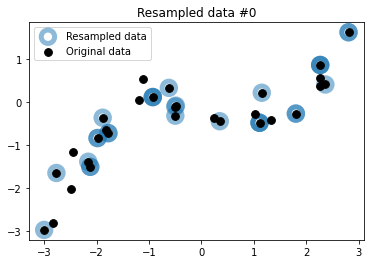

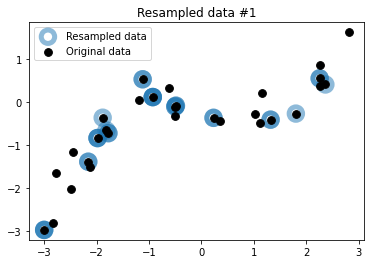

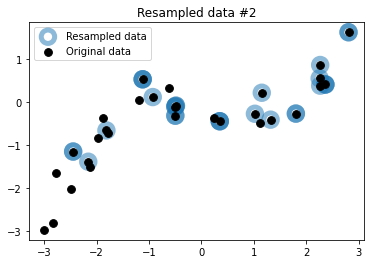

In [9]:
n_bootstraps = 3
for bootstrap_idx in range(n_bootstraps):
    # draw a bootstrap from the original data
    data_bootstrap, target_booststrap = bootstrap_sample(
        data_train, target_train,
    )
    plt.figure()
    plt.scatter(data_bootstrap["Feature"], target_booststrap,
                color="tab:blue", facecolors="none",
                alpha=0.5, label="Resampled data", s=180, linewidth=5)
    plt.scatter(data_train["Feature"], target_train,
                color="black", s=60,
                alpha=1, label="Original data")
    plt.title(f"Resampled data #{bootstrap_idx}")
    plt.legend()

Observe that the 3 variations all share common points with the original dataset. Some of the points are randomly resampled several times and appear as darker blue circles.

The 3 generated bootstrap samples are all different from the original dataset and from each other. To confirm this intuition, we can check the number of unique samples in the bootstrap samples.

In [10]:
# make new synthetic dataset with 100,000 samples
data_train_huge, data_test_huge, target_train_huge = generate_data(
    n_samples=100_000)
# make one bootstrap
data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
    data_train_huge, target_train_huge)
# check ratio of unique values in the bootstrap
ratio_unique_sample = (np.unique(data_bootstrap_sample).size /
                       data_bootstrap_sample.size)
print(
    f"Percentage of samples present in the original dataset: "
    f"{ratio_unique_sample * 100:.1f}%"
)

Percentage of samples present in the original dataset: 63.2%


On average, ~63.2% of the original data points of the original dataset will be present in a given bootstrap sample. The other ~36.8% are __repeated samples__.

We are able to generate many datasets, all slightly different.

Now, we can fit a decision tree for each of these datasets and they all shall be slightly different as well.

In [11]:
# create empty list to store models in
bag_of_trees = []

for bootstrap_idx in range(n_bootstraps):
    # make model
    tree = DecisionTreeRegressor(max_depth=3, random_state=0)
    # take bootstrap sample
    data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
        data_train, target_train)
    # fit model on bootstrap sample
    tree.fit(data_bootstrap_sample, target_bootstrap_sample)
    # add fitted model to list
    bag_of_trees.append(tree)

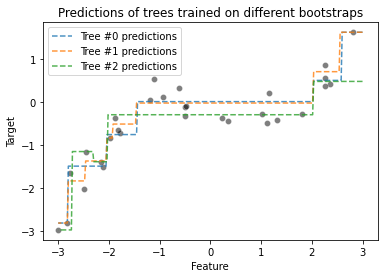

In [12]:
# plot data
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)

for tree_idx, tree in enumerate(bag_of_trees):
    # get predictions for each tree
    tree_predictions = tree.predict(data_test)
    # plot predictions
    plt.plot(data_test, tree_predictions, linestyle="--", alpha=0.8,
             label=f"Tree #{tree_idx} predictions")

plt.legend()
_ = plt.title("Predictions of trees trained on different bootstraps")

<a id="2.2" ></a>
### (ii) Aggregating

Once our trees are fitted and we are able to get predictions for each of them. In regression, the most straightforward way to combine those predictions is just to average them:

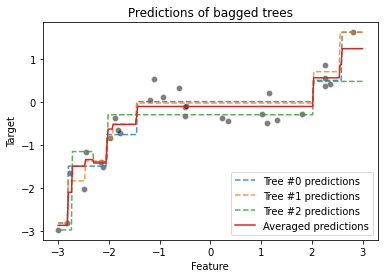

In [13]:
#Using previous example:
# plot synthetic dataset
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)

# create empty array for the predictions of each tree to go into
bag_predictions = []

#cycle through the trees
for tree_idx, tree in enumerate(bag_of_trees):
    tree_predictions = tree.predict(data_test)
    plt.plot(data_test, tree_predictions, linestyle="--", alpha=0.8,
             label=f"Tree #{tree_idx} predictions")
    bag_predictions.append(tree_predictions)

# get the mean predictions
bag_predictions = np.mean(bag_predictions, axis=0)
plt.plot(data_test, bag_predictions, label="Averaged predictions",
         linestyle="-")
# add labels
plt.legend()
_ = plt.title("Predictions of bagged trees")

<a id="2.3" ></a>
### (iii) Bagging (with sklearn)

Scikit-learn implements the bagging procedure as a “meta-estimator”, that is an estimator that wraps another estimator: it takes a base model that is cloned several times and trained independently on each bootstrap sample.

The following code snippet shows how to build a bagging ensemble of decision trees. We set n_estimators=100 instead of 3 in our manual implementation above to get a stronger smoothing effect.

In [14]:
from sklearn.ensemble import BaggingRegressor

# create bagging model using a tree base, with each of the 100 tree having a depth of 3
bagged_trees = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=100,
)
# fit then model on the synthetic data
_ = bagged_trees.fit(data_train, target_train)

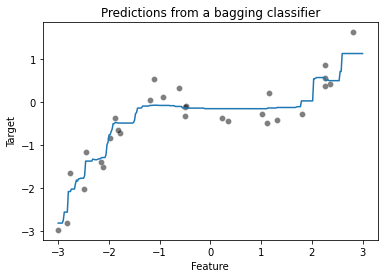

In [15]:
# plot data
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
# make predictions from fitted model
bagged_trees_predictions = bagged_trees.predict(data_test)
# plot predictions
plt.plot(data_test, bagged_trees_predictions)

_ = plt.title("Predictions from a bagging classifier")

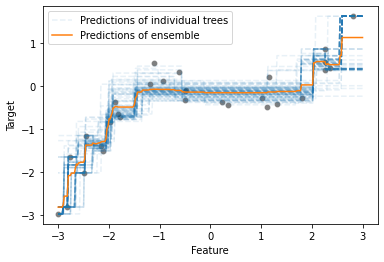

In [16]:
# compare the average prediction with the base predictions
import warnings

with warnings.catch_warnings():
    # ignore scikit-learn warning when accessing bagged estimators
    warnings.filterwarnings(
        "ignore",
        message="X has feature names, but DecisionTreeRegressor was fitted without feature names",
    )
    # cycle through the trees in the model
    for tree_idx, tree in enumerate(bagged_trees.estimators_):
        label = "Predictions of individual trees" if tree_idx == 0 else None
        # get predictions from individual tree
        tree_predictions = tree.predict(data_test)
        # plot predictions from individual tree
        plt.plot(data_test, tree_predictions, linestyle="--", alpha=0.1,
                 color="tab:blue", label=label)

# plot data
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
# get bagging model prediction
bagged_trees_predictions = bagged_trees.predict(data_test)
# plot bagging model prediction
plt.plot(data_test, bagged_trees_predictions,
         color="tab:orange", label="Predictions of ensemble")
_ = plt.legend()

We used a low value of the opacity parameter alpha to better appreciate the overlap in the prediction functions of the individual trees.

This visualization gives some insights on the __uncertainty in the predictions in different areas of the feature space__.

<a id="2.4" ></a>
### (iv) Bagging Complex Pipelines

While we used a decision tree as a base model, nothing prevents us of using __any other type of model__.

As we know that the original data generating function is a noisy polynomial transformation of the input variable, let us try to fit a bagged polynomial regression pipeline on this dataset:

In [17]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

polynomial_regressor = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=4),
    Ridge(alpha=1e-10),
)

This pipeline 
1. First scales the data to the 0-1 range with `MinMaxScaler`. 
2. Then it extracts degree-4 polynomial features. The resulting features will all stay in the 0-1 range by construction: if x lies in the 0-1 range then x ** n also lies in the 0-1 range for any value of n.
3. Then the pipeline feeds the resulting non-linear features to a regularized linear regression model for the final prediction of the target variable.

Note that we intentionally use a small value for the regularization parameter alpha as we expect the bagging ensemble to work well with slightly overfit base models.

The ensemble itself is simply built by passing the resulting pipeline as the `base_estimator` parameter of the BaggingRegressor class:

In [18]:
# create model using 100 base estimators
bagging = BaggingRegressor(
    base_estimator=polynomial_regressor,
    n_estimators=100,
    random_state=0,
)
_ = bagging.fit(data_train, target_train)

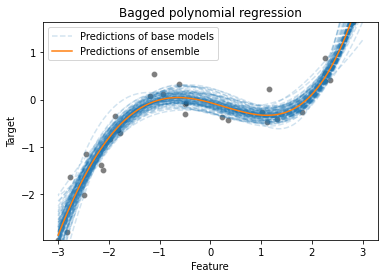

In [19]:
with warnings.catch_warnings():
    # ignore scikit-learn warning when accessing bagged estimators
    warnings.filterwarnings(
        "ignore",
        message="X has feature names, but MinMaxScaler was fitted without feature names",
    )
    # cycle through base pipelines and plot their predictions
    for i, regressor in enumerate(bagging.estimators_):
        regressor_predictions = regressor.predict(data_test)
        base_model_line = plt.plot(
            data_test, regressor_predictions, linestyle="--", alpha=0.2,
            label="Predictions of base models" if i == 0 else None,
            color="tab:blue"
        )

        # plot data
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
# get model predictions
bagging_predictions = bagging.predict(data_test)
#plot model predictions
plt.plot(data_test, bagging_predictions,
         color="tab:orange", label="Predictions of ensemble")
plt.ylim(target_train.min(), target_train.max())
plt.legend()
_ = plt.title("Bagged polynomial regression")

<a id="3" ></a>
## Random Forests

Random forests are a popular model in machine learning. They are a __modification of the bagging algorithm__. In bagging, any classifier or regressor can be used. In random forests, the base classifier or regressor is always a decision tree.

Random forests have another particularity: when training a tree, the search for the best split is done __only on a subset of the original features taken at random__. The __random subsets are different for each split node__. The goal is to inject additional randomization into the learning procedure to try to decorrelate the prediction errors of the individual trees.

Therefore, random forests are using __randomization on both axes of the data matrix__:

- by __bootstrapping samples__ for __each tree__ in the forest;

- __randomly__ selecting a __subset of features at each node__ of the tree.

In [20]:
# load data
adult_census = pd.read_csv("datasets/adult-census.csv")
# split features and target
target_name = "class"
data = adult_census.drop(columns=[target_name, "education-num"])
target = adult_census[target_name]

The adult census contains some categorical data and we __encode the categorical features using an OrdinalEncoder__ since __tree-based models can work very efficiently with such a naive representation of categorical variables__.

__Since there are rare categories in this dataset we need to specifically encode unknown categories at prediction time in order to be able to use cross-validation__. Otherwise some rare categories could only be present on the validation side of the cross-validation split and the OrdinalEncoder would raise an error when calling the its transform method with the data points of the validation set.

#### i) Decision Tree

In [21]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector

#  transformer for categorical data
categorical_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
# preprocessor to only handle Categorical data
preprocessor = make_column_transformer(
    (categorical_encoder, make_column_selector(dtype_include=object)),
    remainder="passthrough"
)

In [22]:
from sklearn.tree import DecisionTreeClassifier

tree = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=0))

In [23]:
from sklearn.model_selection import cross_val_score

scores_tree = cross_val_score(tree, data, target)

print(f"Decision tree classifier: "
      f"{scores_tree.mean():.3f} +/- {scores_tree.std():.3f}")

Decision tree classifier: 0.820 +/- 0.006


#### ii) Bagging with Decision Trees

In [24]:
from sklearn.ensemble import BaggingClassifier

# still using the preprocessor and decision tree as the base model here (50 of them)
bagged_trees = make_pipeline(
    preprocessor,
    BaggingClassifier(
        base_estimator=DecisionTreeClassifier(random_state=0),
        n_estimators=50, n_jobs=2, random_state=0,
    )
)

In [25]:
scores_bagged_trees = cross_val_score(bagged_trees, data, target)

print(f"Bagged decision tree classifier: "
      f"{scores_bagged_trees.mean():.3f} +/- {scores_bagged_trees.std():.3f}")

Bagged decision tree classifier: 0.846 +/- 0.005


#### iii) Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

# again using the preprocessor
random_forest = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=50, n_jobs=2, random_state=0)
)

In [27]:
scores_random_forest = cross_val_score(random_forest, data, target)

print(f"Random forest classifier: "
      f"{scores_random_forest.mean():.3f} +/- "
      f"{scores_random_forest.std():.3f}")

Random forest classifier: 0.851 +/- 0.004


It seems that the random forest is performing slightly better than the bagged trees possibly due to the __randomized selection of the features__ which __decorrelates the prediction errors of individual trees__ and as a consequence make the averaging step more efficient at reducing overfitting.

<u>__Random Forest hyperparameters__</u>

For random forests, it is possible to control the amount of randomness for each split by setting the value of `max_features` hyperparameter:

- `max_features=0.5` means that 50% of the features are considered at each split;

- `max_features=1.0` means that all features are considered at each split which effectively disables feature subsampling.

By default, `RandomForestRegressor` disables feature subsampling while `RandomForestClassifier` uses `max_features=np.sqrt(n_features)`. These default values reflect good practices given in the scientific literature.

However, `max_features` is one of the hyperparameters to consider when tuning a random forest:

- too much randomness in the trees can lead to underfitted base models and can be detrimental for the ensemble as a whole,

- too few randomness in the trees leads to more correlation of the prediction errors and as a result reduce the benefits of the averaging step in terms of overfitting control.

In scikit-learn, the bagging classes also expose a `max_features` parameter. However, `BaggingClassifier` and `BaggingRegressor` are agnostic with respect to their base model and therefore random feature subsampling can only happen __once__ before fitting each base model instead of __several times per base model__ as is the case when adding splits to a given tree.

<a id="4" ></a>
# Boosting

In [28]:
# create function to help with plotting
def plot_decision_function(fitted_classifier, range_features, ax=None):
    """Plot the boundary of the decision function of a classifier."""
    from sklearn.preprocessing import LabelEncoder

    feature_names = list(range_features.keys())
    # create a grid to evaluate all possible samples
    plot_step = 0.02
    xx, yy = np.meshgrid(
        np.arange(*range_features[feature_names[0]], plot_step),
        np.arange(*range_features[feature_names[1]], plot_step),
    )

    # compute the associated prediction
    Z = fitted_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = LabelEncoder().fit_transform(Z)
    Z = Z.reshape(xx.shape)

    # make the plot of the boundary and the data samples
    if ax is None:
        _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu_r")

    return ax

<a id="4.1" ></a>
## Adaptive Boosting (AdaBoost)

<a id="4.1.1"></a>
### (i) Underlying Methodology

In [29]:
# load dataset
penguins = pd.read_csv("datasets/penguins_classification.csv")
# split into target and features
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

data, target = penguins[culmen_columns], penguins[target_column]

# get range of feature values for plotting later
range_features = {
    feature_name: (penguins[feature_name].min() - 1,
                   penguins[feature_name].max() + 1)
    for feature_name in culmen_columns
}

In [30]:
# create model for comparison
tree = DecisionTreeClassifier(max_depth=2, random_state=0)
# fit model
tree.fit(data, target)

DecisionTreeClassifier(max_depth=2, random_state=0)

In [31]:
# get predictions from fitted model
target_predicted = tree.predict(data)
# mark indexes of incorrect predictions
misclassified_samples_idx = np.flatnonzero(target != target_predicted)
# using said indexes, slice the dataframe to retrieve all incorrectly classified data points
data_misclassified = data.iloc[misclassified_samples_idx]

C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


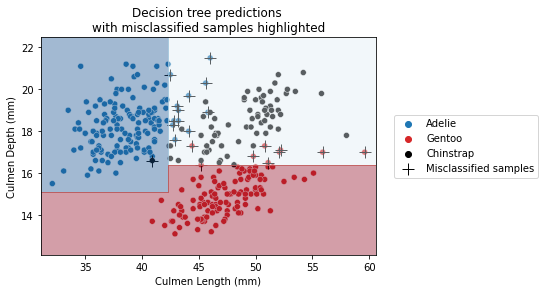

In [32]:
# palette used for plotting
palette = ["tab:blue", "tab:red", "black"]

# plot data
ax = sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                     hue=target_column, palette=palette)

# plot the misclassified samples
sns.scatterplot(data=data_misclassified, x=culmen_columns[0],
                y=culmen_columns[1], label="Misclassified samples",
                marker="+", s=150, color="k")
# add boundaries
_ = plot_decision_function(tree, range_features, ax=ax)
# add labels
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
_ = plt.title("Decision tree predictions \nwith misclassified samples "
              "highlighted")

We observe that several samples have been misclassified by the classifier.

__Boosting__ relies on creating a new classifier which tries to __correct these misclassifications__. In scikit-learn, learners have a parameter `sample_weight` which forces it to pay more attention to samples with higher weights during the training.

This parameter is set when calling `classifier.fit(X, y, sample_weight=weights)`. We will use this trick to create a new classifier by _‘discarding’_ all correctly classified samples and only considering the misclassified samples. Thus, misclassified samples will be assigned a weight of 1 and well classified samples will be assigned a weight of 0.

In [33]:
# create array of zeros
sample_weight = np.zeros_like(target, dtype=int)
# assign 1 to indexes of misclassified values
sample_weight[misclassified_samples_idx] = 1

# create new model
tree = DecisionTreeClassifier(max_depth=2, random_state=0)
# fit new model on the misclassified data points
tree.fit(data, target, sample_weight=sample_weight)

DecisionTreeClassifier(max_depth=2, random_state=0)

C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


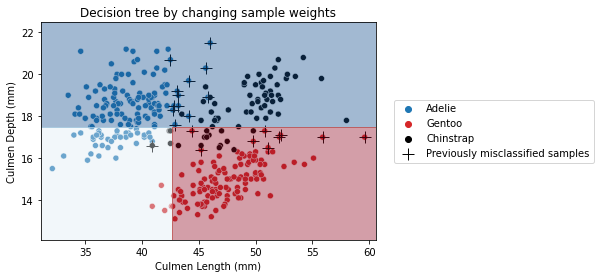

In [34]:
# plot data
ax = sns.scatterplot(data=penguins, x=culmen_columns[0], y=culmen_columns[1],
                hue=target_column, palette=palette)
# plot originally misclassified data points
sns.scatterplot(data=data_misclassified, x=culmen_columns[0],
                y=culmen_columns[1],
                label="Previously misclassified samples",
                marker="+", s=150, color="k")

# add boundaries
_ = plot_decision_function(tree, range_features, ax=ax)
# add labels
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
_ = plt.title("Decision tree by changing sample weights")

We see that the decision function drastically changed. Qualitatively, we see that the previously misclassified samples are now correctly classified.

In [35]:
# get predictions from new tree model
target_predicted = tree.predict(data)
# get the indexes of the now misclassified samples
newly_misclassified_samples_idx = np.flatnonzero(target != target_predicted)
# compare to list of originally misclassifed samples
remaining_misclassified_samples_idx = np.intersect1d(
    misclassified_samples_idx, newly_misclassified_samples_idx
)

print(f"Number of samples previously misclassified and "
      f"still misclassified: {len(remaining_misclassified_samples_idx)}\n"
     f"Number of samples that are NOW misclassified"
      f": {len(newly_misclassified_samples_idx)}")

Number of samples previously misclassified and still misclassified: 0
Number of samples that are NOW misclassified: 105


However, we are now making mistakes on previously well classified samples. Thus, we should __weight__ the predictions of each classifier differently, most probably by using the number of mistakes each classifier is making.

So we could use the classification error to combine both trees.

In [36]:
ensemble_weight = [
    (target.shape[0] - len(misclassified_samples_idx)) / target.shape[0],
    (target.shape[0] - len(newly_misclassified_samples_idx)) / target.shape[0],
]
ensemble_weight

[0.935672514619883, 0.6929824561403509]

The first classifier was 94% accurate and the second one 69% accurate. Therefore, when predicting a class, we should trust the first classifier slightly more than the second one. We could use these accuracy values to weight the predictions of each learner.

To summarize, boosting learns several classifiers, each of which will focus more or less on specific samples of the dataset. __Boosting__ is thus different from __bagging__: here we __never resample our dataset__, we just assign __different weights to the original dataset__.

Boosting requires some strategy to combine the learners together:

- one needs to define a way to compute the weights to be assigned to samples;

- one needs to assign a weight to each learner when making predictions.

Indeed, we defined a really simple scheme to assign sample weights and learner weights. However, there are statistical theories (like in AdaBoost) for how these sample and learner weights can be optimally calculated.

We will use the __AdaBoost classifier__ implemented in scikit-learn and look at the underlying decision tree classifiers trained.

<a id="4.1.2"></a>
### (ii) In Practice

In [37]:
from sklearn.ensemble import AdaBoostClassifier

base_estimator = DecisionTreeClassifier(max_depth=3, random_state=0)
adaboost = AdaBoostClassifier(base_estimator=base_estimator,
                              n_estimators=3, algorithm="SAMME",
                              random_state=0)
adaboost.fit(data, target)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=0),
                   n_estimators=3, random_state=0)

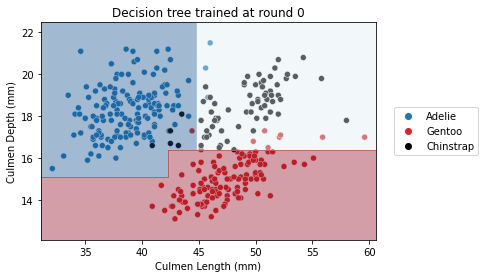

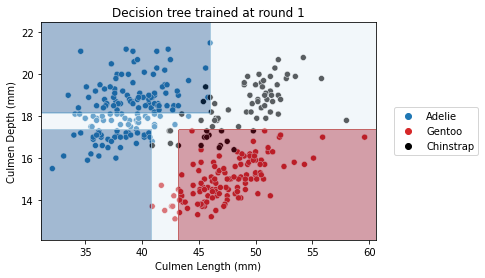

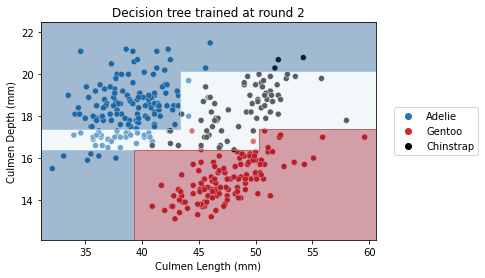

In [38]:
for boosting_round, tree in enumerate(adaboost.estimators_):
    plt.figure()
    # plot new graph of data for each estimator used by the Boosting model
    ax = sns.scatterplot(x=culmen_columns[0], y=culmen_columns[1],
                    hue=target_column, data=penguins,
                    palette=palette)
    # plot the class boundaries decided by the estimator
    _ = plot_decision_function(tree, range_features, ax=ax)
    # add labels
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    _ = plt.title(f"Decision tree trained at round {boosting_round}")

In [39]:
print(f"Weight of each classifier: {adaboost.estimator_weights_}")

Weight of each classifier: [3.58351894 3.46901998 3.03303773]


In [40]:
print(f"Error of each classifier: {adaboost.estimator_errors_}")

Error of each classifier: [0.05263158 0.05864198 0.08787269]


We see that __AdaBoost__ learned three different classifiers, each of which focuses on different samples. Looking at the weights of each learner, we see that the ensemble gives the highest weight to the first classifier. This indeed makes sense when we look at the errors of each classifier. The first classifier also has the highest classification generalization performance.

While AdaBoost is a nice algorithm to demonstrate the internal machinery of boosting algorithms, it is __not the most efficient__. This title is handed to the __gradient-boosting decision tree (GBDT)__ algorithm.

<a id="4.1.3"></a>
### (iii) Overfitting with AdaBoost

In [41]:
# load data for regresion problem
data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0, test_size=0.5)

In [42]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import validation_curve

adaboost = AdaBoostRegressor()
param_range = np.unique(np.logspace(0, 1.8, num=30).astype(int))

train_scores, test_scores = validation_curve(
    adaboost, data_train, target_train,
    param_name="n_estimators", param_range=param_range,
    scoring="neg_mean_absolute_error", n_jobs=2)

train_errors, test_errors = -train_scores, -test_scores

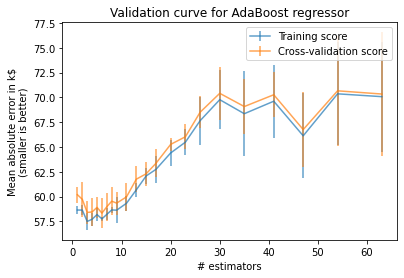

In [43]:
plt.errorbar(param_range, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label="Training score",
             alpha=0.7)
plt.errorbar(param_range, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label="Cross-validation score",
             alpha=0.7)

plt.legend()
plt.ylabel("Mean absolute error in k$\n(smaller is better)")
plt.xlabel("# estimators")
_ = plt.title("Validation curve for AdaBoost regressor")

In [44]:
from sklearn.ensemble import RandomForestRegressor
# try with Random Forest instead
forest = RandomForestRegressor()
train_scores, test_scores = validation_curve(
    forest, data_train, target_train,
    param_name="n_estimators", param_range=param_range,
    scoring="neg_mean_absolute_error", n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

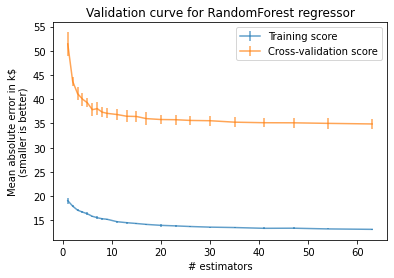

In [45]:
plt.errorbar(param_range, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label="Training score",
             alpha=0.7)
plt.errorbar(param_range, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label="Cross-validation score",
             alpha=0.7)

plt.legend()
plt.ylabel("Mean absolute error in k$\n(smaller is better)")
plt.xlabel("# estimators")
_ = plt.title("Validation curve for RandomForest regressor")

In contrast to the AdaBoost regressor, we can see that increasing the number of trees in the forest will increase the generalization performance (by decreasing the mean absolute error) of the random forest. In fact, __a random forest has less chance to suffer from overfitting than AdaBoost when increasing the number of estimators__.

<a id="4.2" ></a>
## Gradient Boosting

__Gradient-boosting__ differs from __AdaBoost__ due to the following reason: instead of assigning weights to specific samples, GBDT will fit a decision tree on the __residuals error__ (hence the name “gradient”) of the previous tree. Therefore, __each new tree in the ensemble predicts the error made by the previous learner__ instead of predicting the target directly.

<a id="4.2.1"></a>
### (i) Underlying Methodology

In [46]:
# Create a random number generator that will be used to set the randomness
rng = np.random.RandomState(0)


def generate_data(n_samples=50):
    """Generate synthetic dataset. Returns `data_train`, `data_test`,
    `target_train`."""
    x_max, x_min = 1.4, -1.4
    len_x = x_max - x_min
    x = rng.rand(n_samples) * len_x - len_x / 2
    noise = rng.randn(n_samples) * 0.3
    y = x ** 3 - 0.5 * x ** 2 + noise

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(np.linspace(x_max, x_min, num=300),
                             columns=["Feature"])
    target_train = pd.Series(y, name="Target")

    return data_train, data_test, target_train


data_train, data_test, target_train = generate_data()

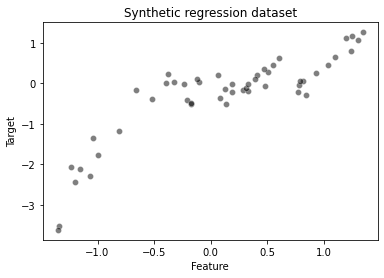

In [47]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
_ = plt.title("Synthetic regression dataset")

In [48]:
# start the sequence of learners with a deliberately shallow tree
tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(data_train, target_train)

target_train_predicted = tree.predict(data_train)
target_test_predicted = tree.predict(data_test)

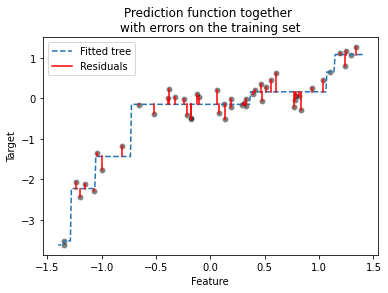

In [49]:
# plot the data
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
# plot the predictions
line_predictions = plt.plot(data_test, target_test_predicted, "--")

# plot the residuals
for value, true, predicted in zip(data_train["Feature"],
                                  target_train, #the actual value
                                  target_train_predicted): # the predicted value
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")
    # plt.plot([x1, x2], [y1, y2], color="red"), here x1 = x2

plt.legend([line_predictions[0], lines_residuals[0]],
           ["Fitted tree", "Residuals"])
_ = plt.title("Prediction function together \nwith errors on the training set")

Since the tree underfits the data, its accuracy is far from perfect on the training data. We can observe this in the figure by looking at the difference between the predictions and the ground-truth data. We represent these errors, called __“Residuals”__, by unbroken red lines.

Indeed, our initial tree was not expressive enough to handle the complexity of the data, as shown by the residuals. In a __gradient-boosting__ algorithm, the idea is to create a second tree which, given the same data data, will try to predict the residuals instead of the vector target. We would therefore have a tree that is able to predict the errors made by the initial tree.

Let’s train such a tree

In [50]:
residuals = target_train - target_train_predicted # the difference between predicted and actual

# make new tree model
tree_residuals = DecisionTreeRegressor(max_depth=5, random_state=0)
# try to predict what the difference will be
tree_residuals.fit(data_train, residuals)

target_train_predicted_residuals = tree_residuals.predict(data_train) # from the 50 training values
target_test_predicted_residuals = tree_residuals.predict(data_test)# from the 300 random test values

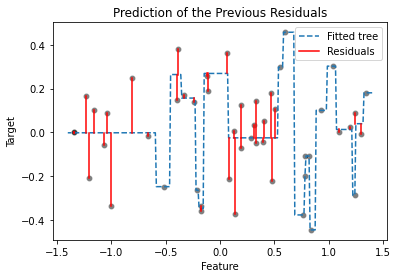

In [51]:
# from the 50 training values, plot what the residuals actually were
sns.scatterplot(x=data_train["Feature"], y=residuals, color="black", alpha=0.5)
# from the 300 test values, plot the predicted y value (predicted residual)
line_predictions = plt.plot(data_test, target_test_predicted_residuals, "--")

# plot the residuals of the predicted residuals
for value, true, predicted in zip(data_train["Feature"],
                                  residuals,
                                  target_train_predicted_residuals):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

plt.legend([line_predictions[0], lines_residuals[0]],
           ["Fitted tree", "Residuals"])
_ = plt.title("Prediction of the Previous Residuals")

We see that this new tree only manages to fit some of the residuals. We will focus on a __specific sample__ from the training set (i.e. we know that the sample will be well predicted using two successive trees). We will use this sample to explain how the predictions of both trees are combined. Let’s first select this sample in `data_train`.

In [52]:
data_max = data_train.iloc[-2, 0] # as it is known
# using the index of the chosen value:
target_true = target_train.iloc[-2]
target_true_residual = residuals.iloc[-2]

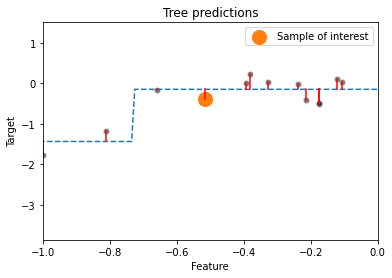

In [53]:
# Plot the original information:
#   * the dataset
#   * the predictions
#   * the initial residuals

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)

plt.plot(data_test, target_test_predicted, "--")

for value, true, predicted in zip(data_train["Feature"],
                                  target_train,
                                  target_train_predicted):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

# Highlight the sample of interest
plt.scatter(data_max, target_true, label="Sample of interest",
            color="tab:orange", s=200)
# focus on a subsection of the graph
plt.xlim([-1, 0])
# add labels
plt.legend()
_ = plt.title("Tree predictions")

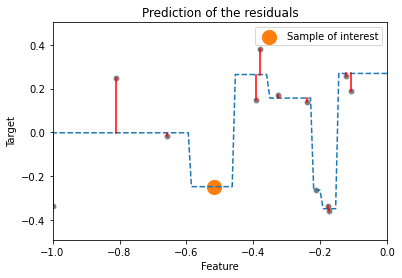

In [54]:
# Plot the previous information:
#   * the residuals committed by the first tree
#   * the residual predictions
#   * the residuals of the residual predictions

sns.scatterplot(x=data_train["Feature"], y=residuals,
                color="black", alpha=0.5)

plt.plot(data_test, target_test_predicted_residuals, "--")

for value, true, predicted in zip(data_train["Feature"],
                                  residuals,
                                  target_train_predicted_residuals):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

# Highlight the sample of interest
plt.scatter(data_max, target_true_residual, label="Sample of interest",
            color="tab:orange", s=200)
# focus on a subsection of the graph
plt.xlim([-1, 0])
#add labels
plt.legend()
_ = plt.title("Prediction of the residuals")

For our sample of interest, our __initial tree__ is making an error (__small residual__). When fitting the second tree, the __residual__ in this case is __perfectly fitted__ and predicted. We will quantitatively check this prediction using the fitted tree. First, let’s check the prediction of the initial tree and compare it with the true value.

In [55]:
print(f"True value to predict for f(x={data_max:.3f}) = {target_true:.3f}")

y_pred_first_tree = tree.predict([[data_max]])[0]
print(f"Prediction of the first decision tree for x={data_max:.3f}: "
      f"y={y_pred_first_tree:.3f}")
print(f"Error of the tree: {target_true - y_pred_first_tree:.3f}")

True value to predict for f(x=-0.517) = -0.393
Prediction of the first decision tree for x=-0.517: y=-0.145
Error of the tree: -0.248


C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [56]:
print(f"Prediction of the residual for x={data_max:.3f}: "
      f"{tree_residuals.predict([[data_max]])[0]:.3f}")

Prediction of the residual for x=-0.517: -0.248


C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


We see that our second tree is capable of predicting the exact residual (error) of our first tree. Therefore, we can __predict the value of x by summing the prediction of the all trees__ in the ensemble.

In [57]:
# sum predictions for chosen datapoint
y_pred_first_and_second_tree = (
    y_pred_first_tree + tree_residuals.predict([[data_max]])[0]
)
print(f"Prediction of the first and second decision trees combined for "
      f"x={data_max:.3f}: y={y_pred_first_and_second_tree:.3f}")
print(f"Error of the tree: {target_true - y_pred_first_and_second_tree:.3f}")

Prediction of the first and second decision trees combined for x=-0.517: y=-0.393
Error of the tree: 0.000


C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


We chose a sample for which only two trees were enough to make the perfect prediction. However, we saw in the previous plot that two trees were not enough to correct the residuals of all samples. Therefore, one needs to add several trees to the ensemble to successfully correct the error. (i.e. the second tree corrects the first tree’s error, while the third tree corrects the second tree’s error and so on.)

<a id="4.2.2"></a>
### (ii) Random Forest Comparison

In [58]:
# load data
data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

In [59]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting = GradientBoostingRegressor(n_estimators=200)

cv_results_gbdt = cross_validate(
    gradient_boosting, data, target, scoring="neg_mean_absolute_error",
    n_jobs=2,
)

In [60]:
print("Gradient Boosting Decision Tree:")
print(f"Mean absolute error via cross-validation: "
      f"{-cv_results_gbdt['test_score'].mean():.3f} +/- "
      f"{cv_results_gbdt['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_gbdt['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_gbdt['score_time'].mean():.3f} seconds")

Gradient Boosting Decision Tree:
Mean absolute error via cross-validation: 46.390 +/- 2.912 k$
Average fit time: 8.043 seconds
Average score time: 0.021 seconds


In [61]:
#from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=200, n_jobs=2)

cv_results_rf = cross_validate(
    random_forest, data, target, scoring="neg_mean_absolute_error",
    n_jobs=2,
)

In [62]:
print("Random Forest:")
print(f"Mean absolute error via cross-validation: "
      f"{-cv_results_rf['test_score'].mean():.3f} +/- "
      f"{cv_results_rf['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_rf['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_rf['score_time'].mean():.3f} seconds")

Random Forest:
Mean absolute error via cross-validation: 46.516 +/- 4.524 k$
Average fit time: 15.803 seconds
Average score time: 0.115 seconds


In term of computation performance, the forest can be parallelized and will benefit from using multiple cores of the CPU. In terms of scoring performance, both algorithms lead to __very close results__.

However, we see that the __gradient boosting is a very fast__ algorithm to predict compared to random forest. This is due to the fact that gradient boosting uses __shallow trees__.

<a id="4.2.3"></a>
### (iii) Overfitting & Early-Stopping

In [63]:
# using same dataset as above
data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0, test_size=0.5)

In [64]:
gbdt = GradientBoostingRegressor(max_depth=5, learning_rate=0.5)

In [65]:
# number of estimators to compare between
param_range = [1, 2, 5, 10, 20, 50, 100]

gbdt_train_scores, gbdt_test_scores = validation_curve(
    gbdt,
    data_train,
    target_train,
    param_name="n_estimators",
    param_range=param_range,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
)
gbdt_train_errors, gbdt_test_errors = -gbdt_train_scores, -gbdt_test_scores

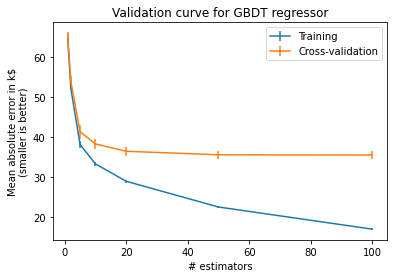

In [66]:
# plot train error
plt.errorbar(
    param_range,
    gbdt_train_errors.mean(axis=1),
    yerr=gbdt_train_errors.std(axis=1),
    label="Training",
)
# plot test error
plt.errorbar(
    param_range,
    gbdt_test_errors.mean(axis=1),
    yerr=gbdt_test_errors.std(axis=1),
    label="Cross-validation",
)

plt.legend()
plt.ylabel("Mean absolute error in k$\n(smaller is better)")
plt.xlabel("# estimators")
_ = plt.title("Validation curve for GBDT regressor")

__Unlike AdaBoost, the gradient boosting model will always improve when increasing the number of trees in the ensemble__. However, it will reach a __plateau__ where adding new trees will just make fitting and scoring __slower__.

To avoid adding new unnecessary tree, gradient boosting offers an __early-stopping option__. Internally, the algorithm will use an <u>out-of-sample set</u> to compute the generalization performance of the model at each addition of a tree. Thus, if the generalization performance is not improving for several iterations, it will stop adding trees.

Below see a gradient-boosting model with `n_estimators=1000`. This number of trees will be too large. It uses the parameter `n_iter_no_change` such that the gradient boosting fitting will stop after adding 5 trees that do not improve the overall generalization performance.

In [67]:
gbdt = GradientBoostingRegressor(n_estimators=1000, n_iter_no_change=5)

gbdt.fit(data_train, target_train)
print(f'Number of trees used in GradientBoostingRegressor with n_iter_no_change set to 5: {gbdt.n_estimators_} (out of 1000)')

C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Number of trees used in GradientBoostingRegressor with n_iter_no_change set to 5: 195 (out of 1000)


<a class="anchor" id="4.2.4"></a>
### (iv) Histogram Boosting

"Histogram gradient boosting” uses a __reduced number of splits__ when building the different trees.

__Random-forest is an efficient__ algorithm since __each tree of the ensemble can be fitted at the same time independently__. Therefore, the algorithm __scales__ efficiently with both the number of cores and the number of samples.

In __gradient-boosting__, the algorithm is a __sequential__ algorithm. It requires the N-1 trees to have been fit to be able to fit the tree at stage N. Therefore, the algorithm is quite computationally expensive. The most expensive part in this algorithm is the search for the best split in the tree which is a brute-force approach: all possible split are evaluated and the best one is picked.

To accelerate the gradient-boosting algorithm, one could reduce the number of splits to be evaluated. As a consequence, the generalization performance of such a tree would be reduced. However, since we are combining several trees in a gradient-boosting, we can add more estimators to overcome this issue.

In [68]:
# recall from before, using a Gradient Boosting model with 200 estimators on the California Housing Dataset
print("Gradient Boosting Decision Tree:")
print(f"Mean absolute error via cross-validation: "
      f"{-cv_results_gbdt['test_score'].mean():.3f} +/- "
      f"{cv_results_gbdt['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_gbdt['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_gbdt['score_time'].mean():.3f} seconds")

Gradient Boosting Decision Tree:
Mean absolute error via cross-validation: 46.390 +/- 2.912 k$
Average fit time: 8.043 seconds
Average score time: 0.021 seconds


In [71]:
# bin the data
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(
    n_bins=256, encode="ordinal", strategy="quantile")

data_trans = discretizer.fit_transform(data)
data_trans

C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:236: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:236: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:236: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\GGN04\Anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:236: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  warnings.warn(


array([[249.,  39., 231., ...,  83., 162.,  30.],
       [248.,  19., 203., ...,  28., 161.,  30.],
       [242.,  49., 249., ..., 125., 160.,  29.],
       ...,
       [ 17.,  15., 126., ...,  49., 200.,  82.],
       [ 23.,  16., 136., ...,  29., 200.,  77.],
       [ 53.,  14., 130., ...,  93., 199.,  81.]])

We see that the discretizer transforms the original data into an integer. This integer represents the bin index when the distribution by quantile is performed. We can check the number of bins per feature.

In [72]:
[len(np.unique(col)) for col in data_trans.T]

[256, 50, 256, 253, 256, 256, 207, 235]

After this transformation, we see that we have __at most 256 unique values per features__. Now, we will use this transformer to discretize data before training the gradient boosting regressor.

In [73]:
# build model utilising transformer
gradient_boosting = make_pipeline(
    discretizer, GradientBoostingRegressor(n_estimators=200))
# evaluate model
cv_results_gbdt = cross_validate(
    gradient_boosting, data, target, scoring="neg_mean_absolute_error",
    n_jobs=2,
)

In [74]:
print("Gradient Boosting Decision Tree with KBinsDiscretizer")
print(f"Mean absolute error via cross-validation: "
      f"{-cv_results_gbdt['test_score'].mean():.3f} +/- "
      f"{cv_results_gbdt['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_gbdt['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_gbdt['score_time'].mean():.3f} seconds")

Gradient Boosting Decision Tree with KBinsDiscretizer
Mean absolute error via cross-validation: 46.136 +/- 2.231 k$
Average fit time: 5.048 seconds
Average score time: 0.020 seconds


Here, we see that the __fit time has been drastically reduced__ but that the __generalization performance of the model is identical__. 

Scikit-learn provides a specific classes which are even more optimized for large dataset, called `HistGradientBoostingClassifier` and `HistGradientBoostingRegressor`. 
- Each feature in the dataset data is first binned by computing histograms, which are later used to evaluate the potential splits. 
- The number of splits to evaluate is then much smaller. This algorithm becomes much more efficient than gradient boosting when the dataset has __over 10,000 samples__.


In [75]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Histogram Boosting model, also with 200 estimators
histogram_gradient_boosting = HistGradientBoostingRegressor(
    max_iter=200, random_state=0)

cv_results_hgbdt = cross_validate(
    histogram_gradient_boosting, data, target,
    scoring="neg_mean_absolute_error", n_jobs=2,
)

In [76]:
print("Histogram Gradient Boosting Decision Tree")
print(f"Mean absolute error via cross-validation: "
      f"{-cv_results_hgbdt['test_score'].mean():.3f} +/- "
      f"{cv_results_hgbdt['test_score'].std():.3f} k$")
print(f"Average fit time: "
      f"{cv_results_hgbdt['fit_time'].mean():.3f} seconds")
print(f"Average score time: "
      f"{cv_results_hgbdt['score_time'].mean():.3f} seconds")

Histogram Gradient Boosting Decision Tree
Mean absolute error via cross-validation: 43.758 +/- 2.694 k$
Average fit time: 2.320 seconds
Average score time: 0.060 seconds


The histogram gradient-boosting is the best algorithm in terms of score. It __will also scale__ when the number of samples increases, while the normal gradient-boosting will not.

<a id="5" ></a>
## Hyperparameters

Note: For the sake of clarity, no cross-validation will be used to estimate the testing error. We are only showing the effect of the parameters on the validation set of what should be the inner cross-validation.

### Random Forest

The main parameter to tune for random forest is the __n_estimators__ parameter. 
- In general, the more trees in the forest, the better the generalization performance will be. 
- However, it will slow down the fitting and prediction time.
The goal is to balance computing time and generalization performance when setting the number of estimators when putting such learner in production.

The __max_depth__ parameter could also be tuned. Sometimes, there is no need to have fully grown trees. However, be aware that with random forest, trees are generally deep since we are seeking to overfit the learners on the bootstrap samples because this will be mitigated by combining them. 
- Assembling underfitted trees (i.e. shallow trees) might also lead to an underfitted forest.

In [79]:
from sklearn.model_selection import RandomizedSearchCV
# we will continue to use the California Housing dataset that was used above

# values to compare
param_distributions = {
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
}
# create model that will search for the best parameter values
search_cv = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=2), param_distributions=param_distributions,
    scoring="neg_mean_absolute_error", n_iter=10, random_state=0, n_jobs=2,
)
# fit the model
search_cv.fit(data_train, target_train)

# select desired columns
columns = [f"param_{name}" for name in param_distributions.keys()]
columns += ["mean_test_score", "rank_test_score"]
# combine results to df
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
# slice by desired columns
cv_results[columns].sort_values(by="rank_test_score")

,param_n_estimators,param_max_leaf_nodes,mean_test_score,rank_test_score
0,500,100,40.779452,1
2,10,100,41.311692,2
7,100,50,43.729264,3
8,1,100,48.359066,4
6,50,20,48.797622,5
1,100,20,48.909239,6
9,10,20,49.603694,7
3,500,10,54.035556,8
4,5,5,60.891978,9
5,5,2,73.266340,10


We can observe that in our grid-search, the largest `max_depth` together with the largest `n_estimators` led to the best generalization performance.

### Gradient-boosting Decision Trees

For gradient-boosting, __parameters are coupled__, so we cannot set the parameters one after the other anymore. The important parameters are __n_estimators__, __max_depth__, and __learning_rate__.

1. __max_depth__

The algorithm fits the error of the previous tree in the ensemble. Thus, fitting fully grown trees will be detrimental.
Indeed, the first tree of the ensemble would perfectly fit (overfit) the data and thus no subsequent tree would be required, since there would be __no residuals__. Therefore, the tree used in gradient-boosting should have a __low depth__, typically between 3 to 8 levels. Having very weak learners at each step will help reducing overfitting.

2. __n_estimators__

The deeper the trees, the faster the residuals will be corrected and __fewer learners are required__. Therefore, __n_estimators should be increased if max_depth is lower__.

3. __learning_rate__ 

When fitting the residuals, we would like the tree to try to correct all possible errors __or__ only a fraction of them. The learning-rate allows you to control this behaviour. 
- A small learning-rate value would only correct the residuals of very few samples. 
- If a large learning-rate is set (e.g., 1), we would fit the residuals of all samples. 
So, with a very __low learning-rate__, we will need __more estimators to correct the overall error__. However, a too large learning-rate tends to obtain an __overfitted ensemble__, similar to having a too large tree depth.

In [81]:
from scipy.stats import loguniform
# we will continue to use the California Housing dataset that was used above

# values to compare
param_distributions = {
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": loguniform(0.01, 1),
}
# create model that will search for the best parameter values
search_cv = RandomizedSearchCV(
    GradientBoostingRegressor(), param_distributions=param_distributions,
    scoring="neg_mean_absolute_error", n_iter=20, random_state=0, n_jobs=2
)
# fit the model
search_cv.fit(data_train, target_train)

# select desired columns
columns = [f"param_{name}" for name in param_distributions.keys()]
columns += ["mean_test_score", "rank_test_score"]
# combine results to df
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
# slice by desired columns
cv_results[columns].sort_values(by="rank_test_score")

,param_n_estimators,param_max_leaf_nodes,param_learning_rate,mean_test_score,rank_test_score
1,200,20,0.160519,34.583517,1
10,200,20,0.109889,35.311259,2
12,200,50,0.110585,35.413688,3
17,500,5,0.771785,37.254935,4
6,500,100,0.709894,37.947178,5
18,10,5,0.637819,42.705564,6
3,500,2,0.07502,43.504858,7
4,100,5,0.0351,46.549344,8
19,5,20,0.202432,61.188817,9
8,5,2,0.462636,64.955190,10


In this search, we see that the `learning_rate` is required to be large enough, i.e. > 0.1. We also observe that for the best ranked models, having a smaller `learning_rate` will require more trees or a larger number of leaves for each tree. However, it is particularly difficult to draw more detailed conclusions since __the best value of a hyperparameter depends on the other hyperparameter values__.